In [1]:
import matplotlib.pyplot as plt
import matplotlib
import os
from fits_reader import shelf,fits_reader
import importlib
import glob
import spec_reader


importlib.reload(fits_reader)
importlib.reload(spec_reader)
importlib.reload(spec_reader.irradiance)
importlib.reload(spec_reader.angle_function)
importlib.reload(shelf)

import gc
import math
import sys
import numpy as np

In [2]:
arms = ["armS","armM","armL"]
home_directory = os.environ['HOME']
season_name = "/WSMR2021May/reduction/2021-06-23"
experiment_name = "/abs_calib/NIR/"
experiment_directory = home_directory + season_name + experiment_name
reduction_shelf = shelf.make_reduction_shelf(experiment_directory)

In [3]:
reduction_shelf.get_all_books()

['①refOD1_&_②Thermal_cut_L__x_③Blank_@500mm',
 '①refOD1_&_②Thermal_cut_L__x_③Blank_@0mm',
 '①refOD1×②Thermal_cut_M__x_③Blank',
 '①absOD1_x_②absOD2_x_③Thermal_cut__S',
 'Sphere_loading_@_250_mm:_①Thermal_cut_L_x_②_Blank_x_③Blank',
 'Sphere_loading_@_500_mm:_①Thermal_cut_L_x_②_Blank_x_③Blank',
 '①refOD1_&_②Thermal_cut_L__x_③Blank_@250mm',
 '①refOD1×②Thermal_cut_L__x_③Blank',
 'Sphere_loading_@_0_mm:_①Thermal_cut_L_x_②_Blank_x_③Blank',
 '①absOD1_×_②Thermal_cut_S__x_③Blank']

In [4]:
#Arm-M
cf_class = spec_reader.irradiance.NIR_CF_Class(reduction_shelf,1200)
book_name = '①refOD1×②Thermal_cut_M__x_③Blank'

Text(0, 0.5, 'BB radiance [W/m^2/sr/nm]')

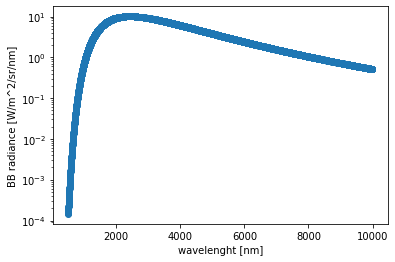

In [5]:
waves = np.arange(500,10000,)
irr = spec_reader.irradiance.get_BB_from_planck(waves,1200)
plt.scatter(waves,irr)
# plt.ylim(10**7,10**10)
# plt.ylim(10**(-3),10**2)
# plt.xlim(800,1600)
plt.yscale("log")
plt.xlabel("wavelenght [nm]")
plt.ylabel("BB radiance [W/m^2/sr/nm]")

Blank doesn't match
[0.00027626 0.0002726  0.00026895 ... 0.01093429 0.01074631 0.01055833]


Text(0, 0.5, 'transparent')

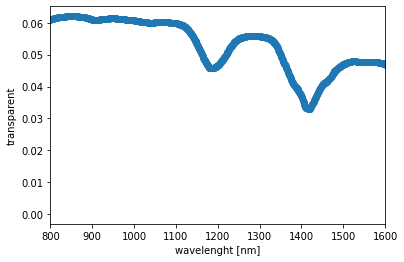

In [6]:
total_transparent = spec_reader.irradiance.get_filter_conbination(book_name)
print(total_transparent)
waves = np.arange(500,2200,)
plt.scatter(waves,total_transparent)
plt.xlim(800,1600)
# plt.ylim(10**11,10**14)
# plt.yscale("log")
plt.xlabel("wavelenght [nm]")
plt.ylabel("transparent")

Blank doesn't match


Text(0, 0.5, 'LS radiance [W/m^2/sr/nm]')

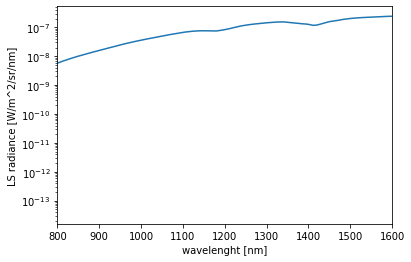

In [7]:
waves,ls_irradiance= cf_class.getIrradiance(book_name)
plt.plot(waves,ls_irradiance)
plt.xlim(800,1600)
# plt.ylim(10,10**-)
plt.yscale("log")
plt.xlabel("wavelenght [nm]")
plt.ylabel("LS radiance [W/m^2/sr/nm]")

In [8]:
armM_wave = waves
armM_radiance = ls_irradiance

In [9]:
#Arm-S
cf_class = spec_reader.irradiance.NIR_CF_Class(reduction_shelf,1200)
book_name = '①absOD1_×_②Thermal_cut_S__x_③Blank'

Text(0, 0.5, 'BB radiance [W/m^2/sr/nm]')

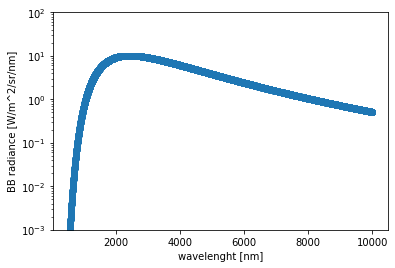

In [10]:
waves = np.arange(500,10000,)
irr = spec_reader.irradiance.get_BB_from_planck(waves,1200)
plt.scatter(waves,irr)
# plt.ylim(10**7,10**10)
plt.ylim(10**(-3),10**2)
# plt.xlim(800,1600)
plt.yscale("log")
plt.xlabel("wavelenght [nm]")
plt.ylabel("BB radiance [W/m^2/sr/nm]")

Blank doesn't match
[0.77537168 0.77522996 0.77508824 ... 0.00243204 0.00242766 0.00242327]


Text(0, 0.5, 'transparent')

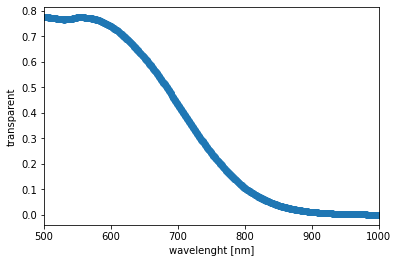

In [11]:
total_transparent = spec_reader.irradiance.get_filter_conbination(book_name)
print(total_transparent)
waves = np.arange(500,2200,)
plt.scatter(waves,total_transparent)
plt.xlim(500,1000)
# plt.ylim(10**11,10**14)
# plt.yscale("log")
plt.xlabel("wavelenght [nm]")
plt.ylabel("transparent")

Blank doesn't match


Text(0, 0.5, 'LS radiance [W/m^2/sr/nm]')

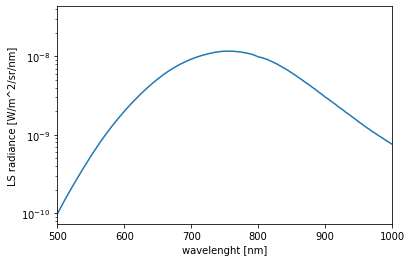

In [12]:
waves,ls_irradiance= cf_class.getIrradiance(book_name)
plt.plot(waves,ls_irradiance)
plt.xlim(500,1000)
# plt.ylim(10,10**-)
plt.yscale("log")
plt.xlabel("wavelenght [nm]")
plt.ylabel("LS radiance [W/m^2/sr/nm]")

In [13]:
armS_wave = waves
armS_radiance = ls_irradiance

In [14]:
#Arm-L
cf_class = spec_reader.irradiance.NIR_CF_Class(reduction_shelf,1200)
book_name = '①refOD1_&_②Thermal_cut_L__x_③Blank_@0mm'

Text(0, 0.5, 'BB radiance [W/m^2/sr/nm]')

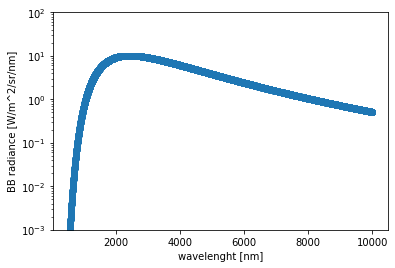

In [15]:
waves = np.arange(500,10000,)
irr = spec_reader.irradiance.get_BB_from_planck(waves,1200)
plt.scatter(waves,irr)
# plt.ylim(10**7,10**10)
plt.ylim(10**(-3),10**2)
# plt.xlim(800,1600)
plt.yscale("log")
plt.xlabel("wavelenght [nm]")
plt.ylabel("BB radiance [W/m^2/sr/nm]")

Blank_@0mm doesn't match
[0.09898793 0.09883303 0.09867814 ... 0.04894662 0.0488518  0.04875697]


Text(0, 0.5, 'transparent')

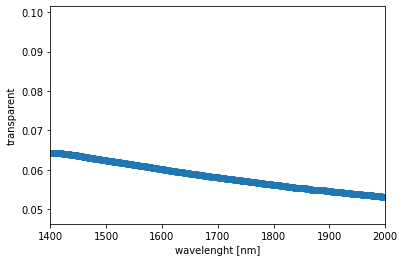

In [16]:
total_transparent = spec_reader.irradiance.get_filter_conbination(book_name)
print(total_transparent)
waves = np.arange(500,2200,)
plt.scatter(waves,total_transparent)
plt.xlim(1400,2000)
# plt.ylim(10**11,10**14)
# plt.yscale("log")
plt.xlabel("wavelenght [nm]")
plt.ylabel("transparent")

Blank_@0mm doesn't match


Text(0, 0.5, 'LS radiance [W/m^2/sr/nm]')

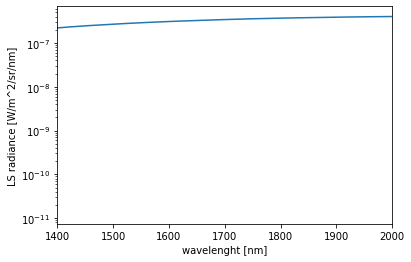

In [17]:
waves,ls_irradiance= cf_class.getIrradiance(book_name)
plt.plot(waves,ls_irradiance)
plt.xlim(1400,2000)
# plt.ylim(10,10**-)
plt.yscale("log")
plt.xlabel("wavelenght [nm]")
plt.ylabel("LS radiance [W/m^2/sr/nm]")

In [18]:
armL_wave = waves
armL_radiance = ls_irradiance

In [19]:
#WPF_transmittance
wpf = sorted(glob.glob(home_directory + '/spectrometer/filter_lib/WPF/pickup/*.csv'))

#blocker_transmittance
blocker = sorted(glob.glob(home_directory + '/spectrometer/filter_lib/blocker/pickup/*.csv'))

#beam_splitter
bs = sorted(glob.glob(home_directory + '/spectrometer/filter_lib/BS/pickup/*.csv'))

In [20]:
import csv
wpf_trans  = []
wavelength_all = []
for i in range(len(wpf)):
    wavelength = []
    trans = []
    with open(wpf[i]) as f:
        rows = csv.reader(f)
        header = next(rows)
        for row in rows:
            wavelength.append(float(row[0]))
            trans.append(float(row[1])/100)
    wpf_trans.append(np.array(trans))
    wavelength_all.append(wavelength)

blocker_trans  = []
for i in range(len(blocker)):
    trans = []
    with open(blocker[i]) as f:
        rows = csv.reader(f)
        header = next(rows)
        for row in rows:
            trans.append(float(row[1])/100)
    blocker_trans.append(np.array(trans))

bs_trans  = []
for i in range(len(bs)):
    trans = []
    with open(bs[i]) as f:
        rows = csv.reader(f)
        header = next(rows)
        for row in rows:
            trans.append(float(row[1])/100)
    bs_trans.append(np.array(trans))

In [21]:
arms1 = wpf_trans[0] * blocker_trans[0] * bs_trans[0] * bs_trans[2]*0.95*0.95*((0.99)**14)
arms2 = wpf_trans[1] * blocker_trans[0] * bs_trans[0] * bs_trans[2]*0.95*0.95*((0.99)**14)
armm1 = wpf_trans[2] * blocker_trans[1] * bs_trans[1] * bs_trans[3]*0.95*0.95*((0.99)**14)
armm2 = wpf_trans[3] * blocker_trans[1] * bs_trans[1] * bs_trans[3]*0.95*0.95*((0.99)**14)
arml1 = wpf_trans[4] * blocker_trans[2] * bs_trans[4] *0.95*0.95*((0.99)**14)
arml2 = wpf_trans[5] * blocker_trans[2] * bs_trans[4] *0.95*0.95*((0.99)**14)

In [22]:
arms_wavelength = wavelength_all[0]
armm_wavelength = wavelength_all[2]
arml_wavelength = wavelength_all[4]
print(arms_wavelength[0],armm_wavelength[0],arml_wavelength[0])

420.0 900.0 1353.0


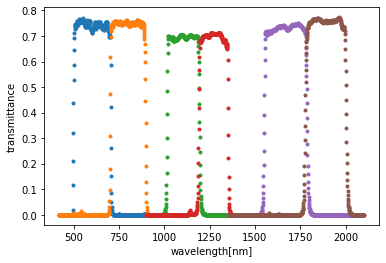

In [23]:
plt.plot(arms_wavelength, arms1, marker='o', lw=0, ms=3)
plt.plot(arms_wavelength, arms2, marker='o', lw=0, ms=3)
plt.plot(armm_wavelength, armm1, marker='o', lw=0, ms=3)
plt.plot(armm_wavelength, armm2, marker='o', lw=0, ms=3)
plt.plot(arml_wavelength, arml1, marker='o', lw=0, ms=3)
plt.plot(arml_wavelength, arml2, marker='o', lw=0, ms=3)
plt.xlabel('wavelength[nm]')
plt.ylabel('transmittance')
plt.show()

In [24]:
#armS
lowers1 = 0
for i in range(len(arms_wavelength)):
    lower_k = arms1[i]
    lowers1 = lowers1 + lower_k
lowers2 = 0
for i in range(len(arms_wavelength)):
    lower_k = arms2[i]
    lowers2 = lowers2 + lower_k
uppers1 = 0
for i in range(len(arms_wavelength)):
    upper_k = (arms_wavelength[i] * 10**(-9) * arms1[i])
    uppers1 = uppers1 + upper_k
uppers2 = 0
for i in range(len(arms_wavelength)):
    upper_k = (arms_wavelength[i] * 10**(-9) * arms2[i])
    uppers2 = uppers2 + upper_k
    
#armM
lowerm1 = 0
for i in range(len(armm_wavelength)):
    lower_k = armm1[i]
    lowerm1 = lowerm1 + lower_k
lowerm2 = 0
for i in range(len(armm_wavelength)):
    lower_k = armm2[i]
    lowerm2 = lowerm2 + lower_k
upperm1 = 0
for i in range(len(armm_wavelength)):
    upper_k = (armm_wavelength[i] * 10**(-9) * armm1[i])
    upperm1 = upperm1 + upper_k
upperm2 = 0
for i in range(len(armm_wavelength)):
    upper_k = (armm_wavelength[i] * 10**(-9) * armm2[i])
    upperm2 = upperm2 + upper_k

#armL
lowerl1 = 0
for i in range(len(arml_wavelength)):
    lower_k = arml1[i]
    lowerl1 = lowerl1 + lower_k
lowerl2 = 0
for i in range(len(arml_wavelength)):
    lower_k = arml2[i]
    lowerl2 = lowerl2 + lower_k
upperl1 = 0
for i in range(len(arml_wavelength)):
    upper_k = (arml_wavelength[i] * 10**(-9) * arml1[i])
    upperl1 = upperl1 + upper_k
upperl2 = 0
for i in range(len(arml_wavelength)):
    upper_k = (arml_wavelength[i] * 10**(-9) * arml2[i])
    upperl2 = upperl2 + upper_k

In [25]:
lambda_cs1 = uppers1 / lowers1
lambda_cs2 = uppers2 / lowers2
print(lambda_cs1*10**9, lambda_cs2*10**9)

600.7870565169055 797.7592330516177


In [26]:
lambda_cm1 = upperm1 / lowerm1
lambda_cm2 = upperm2 / lowerm2
print(lambda_cm1*10**9, lambda_cm2*10**9)

1104.2603460488665 1269.8757405420727


In [27]:
lambda_cl1 = upperl1 / lowerl1
lambda_cl2 = upperl2 / lowerl2
print(lambda_cl1*10**9, lambda_cl2*10**9)

1669.6587785486527 1890.0527792263565


In [28]:
s_short = spec_reader.irradiance.get_BB_from_planck(np.array(arms_wavelength[0:80]),1200)

I_refS = []
for i in range(len(arms_wavelength[0:80])):
    factor_wave = -2.8406 * (10**(-10)) * arms_wavelength[0:80][i] + (8.17827 * (10**(-7)))
    I_refS.append(s_short[i]*factor_wave)

In [29]:
I_refS = I_refS + list(armS_radiance[0:451])
I_refM = armM_radiance[400:1031]
I_refL = armL_radiance[853:1601]

In [30]:
#armS
lows1 = 0
for i in range(len(arms_wavelength)):
    lower_k = (I_refS[i] * arms1[i] * arms_wavelength[i] * 10**(-9))
    lows1 = lows1 + lower_k
lows2 = 0
for i in range(len(arms_wavelength)):
    lower_k = (I_refS[i] * arms2[i] * arms_wavelength[i] * 10**(-9))
    lows2 = lows2 + lower_k

In [31]:
#armM
lowm1 = 0
for i in range(len(armm_wavelength)):
    lower_k = (I_refM[i] * armm1[i] * armm_wavelength[i] * 10**(-9))
    lowm1 = lowm1 + lower_k
lowm2 = 0
for i in range(len(armm_wavelength)):
    lower_k = (I_refM[i] * armm2[i] * armm_wavelength[i] * 10**(-9))
    lowm2 = lowm2 + lower_k

In [32]:
#armL
lowl1 = 0
for i in range(len(arml_wavelength)):
    lower_k = (I_refL[i] * arml1[i] * arml_wavelength[i] * 10**(-9))
    lowl1 = lowl1 + lower_k
lowl2 = 0
for i in range(len(arml_wavelength)):
    lower_k = (I_refL[i] * arml2[i] * arml_wavelength[i] * 10**(-9))
    lowl2 = lowl2 + lower_k

In [33]:
area_t = 5.43 * 10 **-2
pixel_t = 3.76 * 10**-10
det_t = 0.8
topt_t = 0.9*0.9*(0.98**12)*0.9
h_t = 6.6 * 10**-34
c_t = 3 * 10**8

In [34]:
cf1_s = lows1 * h_t * c_t / (area_t * pixel_t * det_t * lambda_cs1 * lows1 * lowers1)
cf2_s = lows2 * h_t * c_t / (area_t * pixel_t * det_t * lambda_cs2 * lows2 * lowers2)

In [35]:
cf1_m = lowm1 * h_t * c_t / (area_t * pixel_t * det_t * lambda_cm1 * lowm1 * lowerm1)
cf2_m = lowm2 * h_t * c_t / (area_t * pixel_t * det_t * lambda_cm2 * lowm2 * lowerm2)

In [36]:
cf1_l = lowl1 * h_t * c_t / (area_t * pixel_t * det_t * lambda_cl1 * lowl1 * lowerl1)
cf2_l = lowl2 * h_t * c_t / (area_t * pixel_t * det_t * lambda_cl2 * lowl2 * lowerl2)

In [37]:
cf1_s, cf2_s, cf1_m, cf2_m, cf1_l, cf2_l

(1.312110769156279e-10,
 1.0365677378840749e-10,
 8.763510476840116e-11,
 8.357047654671252e-11,
 4.1684006154173365e-11,
 3.7201471678184156e-11)

In [38]:
wave_wpf_calc = [lambda_cs1*10**9, lambda_cs2*10**9, lambda_cm1*10**9, lambda_cm2*10**9, lambda_cl1*10**9, lambda_cl2*10**9]
cf_wpf_calc = [cf1_s, cf2_s, cf1_m, cf2_m, cf1_l, cf2_l]

In [39]:
si = [8.459531, 25.087439, 321.3988, 536.5211, 1871.7863, 1408.2406]

In [40]:
cf1_s_m = lows1 / (si[0] * lambda_cs1 * lowers1)
cf2_s_m = lows2 / (si[1] * lambda_cs2 * lowers2)

In [41]:
cf1_m_m = lowm1 / (si[2] * lambda_cm1 * lowerm1)
cf2_m_m = lowm2 / (si[3] * lambda_cm2 * lowerm2)

In [42]:
cf1_l_m = lowl1 / (si[4] * lambda_cl1 * lowerl1)
cf2_l_m = lowl2 / (si[5] * lambda_cl2 * lowerl2)

In [43]:
cf_wpf_measure = [cf1_s_m, cf2_s_m, cf1_m_m, cf2_m_m, cf1_l_m, cf2_l_m]
print(cf_wpf_measure)

[3.995348126274913e-10, 3.413394103295021e-10, 2.0161504124614757e-10, 2.3455309661733074e-10, 1.7820160638310888e-10, 2.7485406913543353e-10]


In [44]:
arms_lvf = blocker_trans[0] * bs_trans[0] * bs_trans[2]*0.95*0.95*((0.99)**14) * 0.99
armm_lvf = blocker_trans[1] * bs_trans[1] * bs_trans[3]*0.95*0.95*((0.99)**14) * 0.95
arml_lvf = blocker_trans[2] * bs_trans[4] *0.95*0.95*((0.99)**14) * 0.98

In [45]:
cf_s_lvf = []
for i in range(len(arms_wavelength)):
    if arms_lvf[i]==0:
        cf_s_lvf.append(0)
    else:
        cf_s_lvf.append((25 * h_t * c_t) / (area_t * pixel_t * det_t * arms_lvf[i] * (arms_wavelength[i]**2) * 10**(-9)))
cf_m_lvf = []
for i in range(len(armm_wavelength)):
    if armm_lvf[i]==0:
        cf_m_lvf.append(0)
    else:
        cf_m_lvf.append((25 * h_t * c_t) / (area_t * pixel_t * det_t * armm_lvf[i] * (armm_wavelength[i]**2) * 10**(-9)))
cf_l_lvf = []
for i in range(len(arml_wavelength)):
    if arml_lvf[i]==0:
        cf_l_lvf.append(0)
    else:
        cf_l_lvf.append((25 * h_t * c_t) / (area_t * pixel_t * det_t * arml_lvf[i] * (arml_wavelength[i]**2) * 10**(-9)))

In [46]:
cf_lvf_calc = [cf_s_lvf, cf_m_lvf, cf_l_lvf]
wavelength_calc = [arms_wavelength, armm_wavelength, arml_wavelength]

In [47]:
# arm_name = "armM"
# book_name = '①refOD1×②Thermal_cut_M__x_③Blank'

# w,cf,cf_sterr= cf_class.calc_CF(book_name,arm_name)

# fig,ax = plt.subplots()
# ax.plot(w[300:-300],cf[300:-300],label=arm_name)
# err_up = cf[300:-300] + cf_sterr[300:-300]
# err_down = cf[300:-300] - cf_sterr[300:-300]
# ax.fill_between(w[300:-300],err_down ,err_up, alpha=0.2)
# ax.set_xlabel("wavelenght [nm]")
# ax.set_ylabel("CF")
# ax.set_ylim(10**-10,10**-8)
# ax.set_yscale("log")

Blank_@0mm doesn't match
5


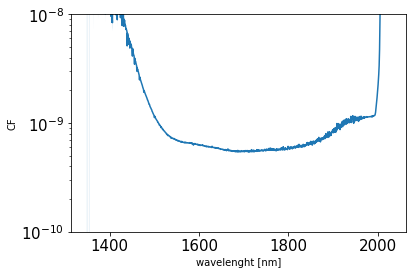

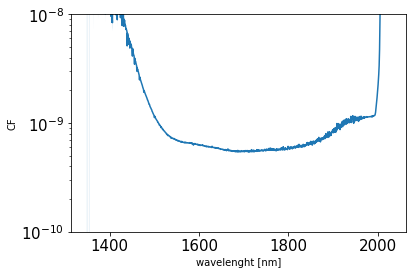

In [48]:
book_name = '①refOD1_&_②Thermal_cut_L__x_③Blank_@0mm'
arm_name = "armL"

fig,ax = plt.subplots()
w,cf,cf_sterr= cf_class.calc_CF(book_name,arm_name)

ax.plot(w[300:-300],cf[300:-300],label=arm_name)
err_up = cf[300:-300] + cf_sterr[300:-300]
err_down = cf[300:-300] - cf_sterr[300:-300]
ax.fill_between(w[300:-300],err_down ,err_up, alpha=0.2)
ax.set_xlabel("wavelenght [nm]")
ax.set_ylabel("CF")
ax.set_ylim(10**-10,10**-8)
ax.set_yscale("log")
# # ax.plot(w,cf)
# ax.set_xlabel("wavelenght [nm]")
# ax.set_ylabel("CF")

# ax.set_ylim(10**-10,10**-8)
# ax.set_yscale("log")
plt.tick_params(labelsize=15)
display(fig)

In [49]:
import os
import csv

file = "./csv/"+arm_name+".csv"
with open(file,'w',newline='')  as f :
    csv_writer = csv.writer(f) #ファイルオブジェクトをcsv.writerオブジェクトに変換
    csv_writer.writerows(np.array((w,cf,cf_sterr)).T) #行一括追加

Blank doesn't match
5


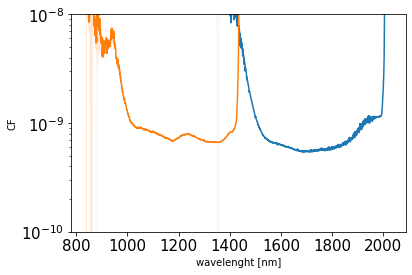

In [50]:
book_name = '①refOD1×②Thermal_cut_M__x_③Blank'
arm_name = "armM"

w,cf,cf_sterr= cf_class.calc_CF(book_name,arm_name)

ax.plot(w[300:-300],cf[300:-300],label=arm_name)
err_up = cf[300:-300] + cf_sterr[300:-300]
err_down = cf[300:-300] - cf_sterr[300:-300]
ax.fill_between(w[300:-300],err_down ,err_up, alpha=0.2)
ax.set_xlabel("wavelenght [nm]")
ax.set_ylabel("CF")
ax.set_ylim(10**-10,10**-8)
ax.set_yscale("log")
# # ax.plot(w,cf)
# ax.set_xlabel("wavelenght [nm]")
# ax.set_ylabel("CF")

# ax.set_ylim(10**-10,10**-8)
# ax.set_yscale("log")
display(fig)

file = "./csv/"+arm_name+".csv"
with open(file,'w',newline='')  as f :
    csv_writer = csv.writer(f) #ファイルオブジェクトをcsv.writerオブジェクトに変換
    csv_writer.writerows(np.array((w,cf,cf_sterr)).T) #行一括追加

Blank doesn't match
5


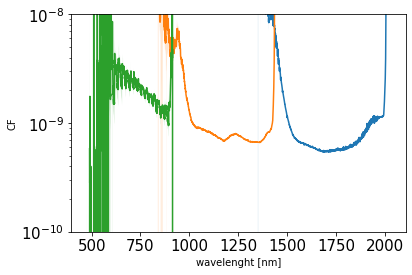

In [51]:
book_name = '①absOD1_×_②Thermal_cut_S__x_③Blank'
arm_name = "armS"

w,cf,cf_sterr= cf_class.calc_CF(book_name,arm_name)

ax.plot(w[300:-300],cf[300:-300],label=arm_name)
err_up = cf[300:-300] + cf_sterr[300:-300]
err_down = cf[300:-300] - cf_sterr[300:-300]
ax.fill_between(w[300:-300],err_down ,err_up, alpha=0.2)
ax.set_xlabel("wavelenght [nm]")
ax.set_ylabel("CF")
ax.set_ylim(10**-10,10**-8)
ax.set_yscale("log")
display(fig)

file = "./csv/"+arm_name+".csv"
with open(file,'w',newline='')  as f :
    csv_writer = csv.writer(f) #ファイルオブジェクトをcsv.writerオブジェクトに変換
    csv_writer.writerows(np.array((w,cf,cf_sterr)).T) #行一括追加

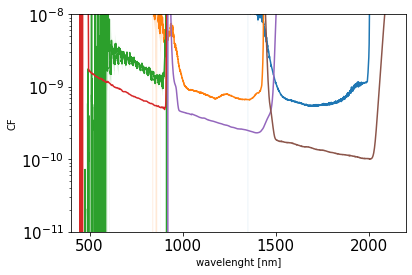

In [52]:
for i in range(3):
    ax.plot(wavelength_calc[i], cf_lvf_calc[i], label=arms[i]+'calculated')
ax.set_xlim(400,2200)
ax.set_ylim(10**-11,10**-8)
display(fig)

file = "./csv/arms_calc.csv"
with open(file,'w',newline='')  as f :
    csv_writer = csv.writer(f) #ファイルオブジェクトをcsv.writerオブジェクトに変換
    csv_writer.writerows(np.array((wavelength_calc[0],cf_lvf_calc[0])).T) #行一括追加

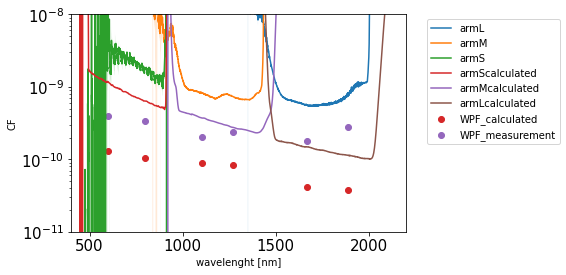

In [53]:
ax.scatter(wave_wpf_calc,cf_wpf_calc,label= "WPF_calculated")
ax.scatter(wave_wpf_calc,cf_wpf_measure,label= "WPF_measurement")
ax.set_ylim(10**-11,10**-8)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
display(fig)

In [54]:
wave_wl_calc = [600.7870565169055, 797.7592330516177]
cf_wl_calc = [1.3121107691562786e-10, 1.036567737884075e-10]

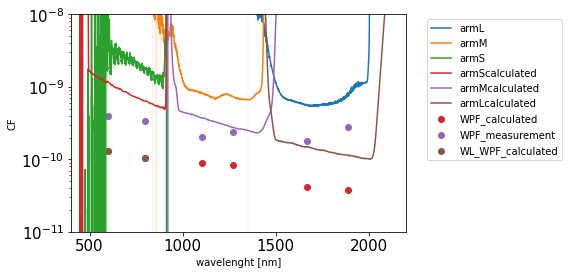

In [55]:
ax.scatter(wave_wl_calc,cf_wl_calc,label= "WL_WPF_calculated")
ax.set_ylim(10**-11,10**-8)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
display(fig)

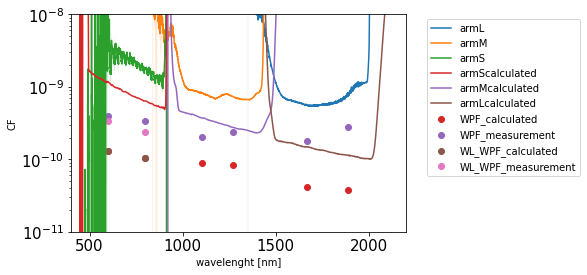

In [56]:
cf_wl_measure = [3.3556970217447e-10, 2.3772429206896676e-10]
ax.scatter(wave_wl_calc,cf_wl_measure,label= "WL_WPF_measurement")
ax.set_ylim(10**-11,10**-8)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
display(fig)

[[6.00787057e+02 1.31211077e-10 3.99534813e-10 3.35569702e-10]
 [7.97759233e+02 1.03656774e-10 3.41339410e-10 2.37724292e-10]
 [1.10426035e+03 8.76351048e-11 2.01615041e-10 0.00000000e+00]
 [1.26987574e+03 8.35704765e-11 2.34553097e-10 0.00000000e+00]
 [1.66965878e+03 4.16840062e-11 1.78201606e-10 0.00000000e+00]
 [1.89005278e+03 3.72014717e-11 2.74854069e-10 0.00000000e+00]]


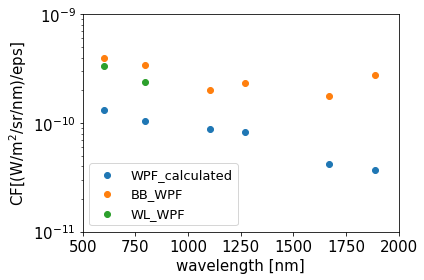

In [81]:
fig,ax = plt.subplots()
ax.scatter(wave_wpf_calc,cf_wpf_calc,label= "WPF_calculated")
ax.scatter(wave_wpf_calc,cf_wpf_measure,label= "BB_WPF")
# ax.scatter(wave_wl_calc,cf_wl_calc,label= "WL_WPF_calculated")
ax.scatter(wave_wl_calc,cf_wl_measure,label= "WL_WPF")

ax.legend(fontsize=13, loc='lower left')
ax.set_xlim(500,2000)
ax.set_ylim(10**-11,10**-9)
ax.set_yscale("log")
ax.set_xlabel("wavelength [nm]", fontsize=15)
ax.set_ylabel("CF[(W/$\mathrm{m^2}$/sr/nm)/eps]", fontsize=15)
plt.tick_params(labelsize=15)
plt.tight_layout()


file = "./csv/CF_WPF.csv"
save_data = np.array([wave_wpf_calc,cf_wpf_calc,cf_wpf_measure,cf_wl_measure+[0,0,0,0]]).T
print(save_data)
with open(file,'w',newline='')  as f :
    csv_writer = csv.writer(f) #ファイルオブジェクトをcsv.writerオブジェクトに変換
    csv_writer.writerow(np.array(("wavelength","calculation","BB","WL"))) #行一括追加
    csv_writer.writerows(save_data) #行一括追加    

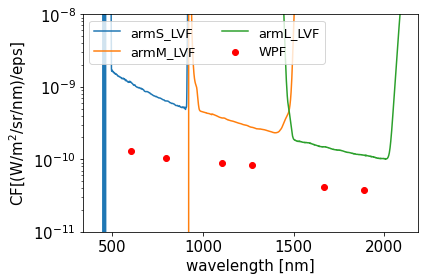

In [58]:
fig,ax = plt.subplots()
for i in range(3):
    ax.plot(wavelength_calc[i], cf_lvf_calc[i], label=arms[i]+"_LVF")
    
ax.scatter(wave_wpf_calc,cf_wpf_calc,label= "WPF", color='red')
# ax.scatter(wave_wpf_calc,cf_wpf_measure,label= "BB_WPF")
# ax.scatter(wave_wl_calc,cf_wl_measure,label= "WL_WPF")

ax.set_xlabel("wavelength [nm]", fontsize=15)
ax.set_ylabel("CF[(W/$\mathrm{m^2}$/sr/nm)/eps]", fontsize=15)
ax.legend(fontsize=13, loc='upper left', ncol=2)
ax.set_yscale("log")
ax.set_ylim(10**-11,10**-8)
plt.tick_params(labelsize=15)
plt.tight_layout()

/home/ciber2/python/main/calibration/fits_reader/shelf.py:100: RuntimeWarning: Mean of empty slice
  img = np.nanmean(imgs,axis=0)
/home/ciber2/python/main/calibration/fits_reader/shelf.py:104: RuntimeWarning: Mean of empty slice
  bg_img = np.nanmean(bg_imgs,axis=0)


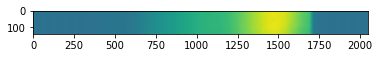

Text(0, 0.5, 'eps')

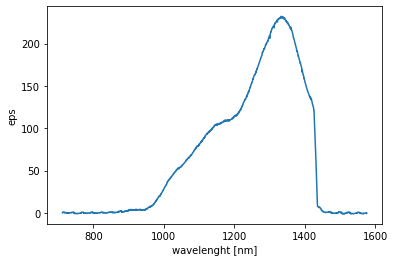

In [59]:
arm_name = "armM"
book_name = '①refOD1×②Thermal_cut_M__x_③Blank'

img =  cf_class.get_lvf_img(book_name,arm_name)
plt.imshow(np.fliplr(img))
plt.show()
w,eps= cf_class.get_wv_vs_eps_at_lvf(book_name,arm_name)
plt.plot(w,eps)
plt.xlabel("wavelenght [nm]")
plt.ylabel("eps")

In [60]:
wvlength_nm = np.arange(500,2200)
wvlength = wvlength_nm * 10**-9

area_t = 5.43 * 10 **-2
pixel_t = 3.76 * 10**-10
det_t = 0.8
topt_t = 0.9*0.9*(0.98**12)*0.9
h_t = 6.6 * 10**-34
c_t = 3 * 10**8

cf_t = (25*h_t*c_t) / (area_t*pixel_t*det_t*topt_t*(wvlength**2)*(10**9))

In [61]:

w,cf= spec_reader.irradiance.get_cf_from_theory()
ax.plot(w,cf,label="estimate")

In [62]:
import csv
file_path = "./lib/sphere_transmittance/Lsphere_relativeT.csv"
with open(file_path) as csvfile:
        reader = csv.reader(csvfile)
        rawData = [row for row in reader]
# print(rawData)
rawData_np = np.array(rawData,dtype=np.float32)
w = rawData_np.T[0]
t = rawData_np.T[1]

print(w)
print(t)

[ 519.201  519.574  519.947 ... 1171.418 1171.683 1171.948]
[1.        1.        1.        ... 0.9405485 0.9402739 0.9402739]
